In [1]:
%matplotlib inline

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import io
import codecs
import re
from dateutil import parser
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud
from collections import Counter, defaultdict
from pykakasi import kakasi
sns.set(color_codes=True)

# Load data

In [2]:
today = datetime.date.today() #- datetime.timedelta(3)
until = str(today)
print(until)

2018-05-15


In [3]:
#YH_df = pd.read_csv("tweet/" + until + "/yawatahama_" + until + ".csv", sep = '\t', encoding='utf-16')
#YH_df = pd.read_csv("tweet/2018-05-08/yawatahama_2018-05-08.csv", sep = '\t', encoding='utf-16')
#YH_df = pd.read_csv("tweet/2018-05-08/iidashi_2018-05-08.csv", sep = '\t', encoding='utf-16')

In [4]:
words = ['八幡浜', 'マーマレード大会', 'どーや市場', 'どーや食堂', '日土小学校', 'アゴラマルシェ', 'もっきんろーど', '諏訪崎', 
         '平家谷', 'みなと湯', 'ゆめみかん', 'はまぽん']
#words = ['飯田市', '飯田線秘境駅', '飯田水引', '下栗の里', '遠山郷', 'りんご並木', 'しらびそ高原', '野底山森林公園']

Kakasi = kakasi()

Kakasi.setMode('H', 'a')
Kakasi.setMode('K', 'a')
Kakasi.setMode('J', 'a')

conv = Kakasi.getConverter()
YH_df = pd.DataFrame()
for word in words:
    df = pd.read_csv('tweet/' + until + '/' + conv.do(word) + '_' + until + '.csv', sep = '\t',encoding='utf-16')
    YH_df = pd.concat([YH_df, df])


# EDA

In [5]:
print("num of tweet: ", YH_df.shape[0])

num of tweet:  1071


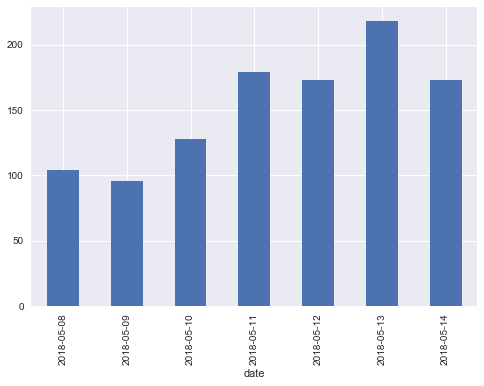

In [6]:
YH_df["date"] = pd.to_datetime(YH_df["created_at"], errors='coerce')
YH_df.groupby(YH_df["date"].dt.date).date.count().plot(kind="bar")

# WordCloud (only noun)

In [7]:
YH_df = YH_df[YH_df['text'].notnull()]

In [8]:
#半角英字
alphaReg = re.compile(r'^[a-zA-Z]+$')
def isalpha(s):
    return alphaReg.match(s) is not None

In [9]:
# janome 形態素分解
def janome_analysis(sentences, output):
    t = Tokenizer()
    words_count = defaultdict(int)
    words = []
    for sentence in sentences:
        tokens = t.tokenize(sentence)
        for token in tokens:
            # 品詞を取り出し
            partOfSpeech1 = token.part_of_speech.split(',')[0]
            partOfSpeech2 = token.part_of_speech.split(',')[1]
            
            if output == "normal":
                if partOfSpeech2 == '固有名詞' or partOfSpeech1 == '形容詞':
#                     if (token.base_form != ':' and 
#                         token.base_form != '@' and
#                         token.base_form != 'RT'):
    #                    token.base_form != '#' and 
    #                     token.base_form != '-' and
    #                     token.base_form != '/' and
    #                     token.base_form != '(' and
    #                     token.base_form != ')' and
    #                     token.base_form != '.'):
                    if isalpha(token.base_form) == False: 
                        words_count[token.base_form] += 1
                        words.append(token.base_form)
            elif output == "cloud":
                if partOfSpeech1 == '名詞':

                    words_count[token.base_form] += 1
                    words.append(token.base_form)
    return words_count, words

In [10]:
texts = YH_df['text'].str.replace('http\S+', '', case=False)
words_count, words = janome_analysis(texts, "cloud")
text = ' '.join(words)

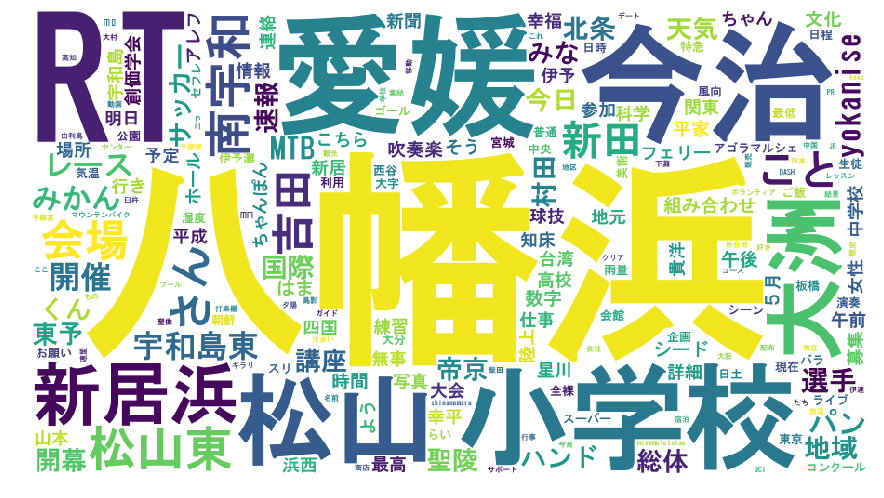

In [11]:
fpath = "C:\Windows\Fonts\HGRGE.TTC"
#word cloud
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Explore frequent word (proper nouns and adjective)

In [12]:
YH_wo_rt = YH_df[YH_df['RT']==False]
YH_wo_rt = YH_wo_rt['text'].str.replace('http\S+', '', case=False)

In [13]:
words_count2, words2 = janome_analysis(YH_wo_rt, "normal")

In [14]:
Counter(words2).most_common()[:5]

[('八幡浜', 660), ('愛媛', 202), ('松山', 39), ('いい', 32), ('宇和島', 31)]

# Sentiment analysis

In [15]:
class CorpusElement:
    def __init__(self, text='', tokens=[], pn_scores=[]):
        self.text = text # テキスト本文
        self.tokens = tokens # 構文木解析されたトークンのリスト
        self.pn_scores = pn_scores # 感情極性値(後述)


# CorpusElementのリスト
naive_corpus = []

naive_tokenizer = Tokenizer()

for text in YH_wo_rt:
    tokens = naive_tokenizer.tokenize(text)
    element = CorpusElement(text, tokens)
    naive_corpus.append(element)

# 最初の1文章の形態素解析結果を表示
# for token in naive_corpus[0].tokens:
#     print(token)

In [16]:
# pn_ja.dicファイルから、単語をキー、極性値を値とする辞書を得る
def load_pn_dict():
    dic = {}
    
    with codecs.open('./pn_ja.dic', 'r', 'shift_jis') as f:
        lines = f.readlines()
        
        for line in lines:
            # 各行は"良い:よい:形容詞:0.999995"
            columns = line.split(':')
            dic[columns[0]] = float(columns[3])
            
    return dic

In [17]:
# トークンリストから極性値リストを得る
def get_pn_scores(tokens, pn_dic):
    scores = []
    
    for surface in [t.surface for t in tokens if t.part_of_speech.split(',')[0] in ['動詞','名詞', '形容詞', '副詞']]:
        if surface in pn_dic:
            scores.append(pn_dic[surface])
    
    if len(scores) == 0:
        scores.append(0)
    
    return scores

In [18]:
# 感情極性対応表のロード
pn_dic = load_pn_dict()

# 各文章の極性値リストを得る
for element in naive_corpus:
    element.pn_scores = get_pn_scores(element.tokens, pn_dic)

In [19]:
# 平均値が最も高い5件を表示
print('------------Show the 5 most postiive tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores), reverse=True)[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')


# 平均値が最も低い5件を表示
print('------------Show the 5 most negative tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores))[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')

#     for surface in [t.surface for t in element.tokens if t.part_of_speech.split(',')[0] in ['動詞','名詞', '形容詞', '副詞']]:
#         if surface in pn_dic:
#             print(surface)
    
#     print(element.pn_scores)
#     print('')

------------Show the 5 most postiive tweets------------------
Average: 0.964
Title: あれ、どこだっけか、ここ（笑）わかんないけどもう少しで八幡浜です。

Average: 0.964
Title: 八幡浜って


Average: 0.669
Title: 良い眺め。


Average: 0.653
Title: 八幡浜での道産子の活躍、期待しています！頑張れ👍👍👍

Average: 0.434
Title: 地味に八幡浜チャンポンのゆるキャラもいた笑 

------------Show the 5 most negative tweets------------------
Average: -0.993
Title: 八幡浜で目に龍が入り込んだようだ

Average: -0.993
Title: ｶﾄﾓﾘﾕｷ。こいつ最低。愛媛の恥。八幡浜の恥。ホント最低。

Average: -0.991
Title: 泥の八幡浜 

Average: -0.979
Title: そして八幡浜が気になる。ソワソワ…

Average: -0.974
Title: 八幡浜に二つ目がいないなんて。。。時代は変わったなあ。。



# Check the most retweeted tweet

In [20]:
for i in range(5):
    print('num of retweet: ', YH_df['text'].value_counts().tolist()[i])
    print(YH_df['text'].value_counts().index.tolist()[i])
    print('')
    print('------------------------------------------------------------------')

num of retweet:  41
RT @yokanise12: 【速報】
県総体サッカー組み合わせ

①今治東-南宇和/三島
新居浜西-新田
済美-八幡浜工
④松山工-今治西

③新居浜工-東予/聖陵
吉田-今治工
帝京第五-松山北
②宇和島東-松山東/大洲

数字はシード順

6/2（土）開幕
6/9（土）…

------------------------------------------------------------------
num of retweet:  25
RT @yokanise12: 会場別

6/2（土）
◎北条陸上
9:30南宇和-三島
12:50新居浜西-新田
14:45今治東-南宇和/三島

◎北条球技
9:30松山東-大洲
11:10今治西-松山工
12:50吉田-今治工
14:45宇和島東-松山東/大洲

◎しおさ…

------------------------------------------------------------------
num of retweet:  19
RT @3110mo: 山本幸平選手が全裸に見えるくらいすごい泥の八幡浜のゴールシーン
https://t.co/X9Tq9dgfZl https://t.co/CYPrIA1HqD

------------------------------------------------------------------
num of retweet:  17
RT @kenc0224: 【村田町歴史みらい館 企画展 政宗集結す！〜小学校に配布された伊達政宗塑像〜】
・開催日時　平成30年4月28日（土）〜6月24日（日）
・開催時間　午前9時〜午後4時30分
・所在地　　宮城県柴田郡村田町大字村田字迫85

👇詳細はこちらから（現在…

------------------------------------------------------------------
num of retweet:  15
RT @minemototakao: 土、日と台湾でのハンドパン講座とホールライブ演奏無事終わりました。
嬉しいことに5/16小学校でのハンドパン講座、5/20に打楽器レッスン生徒への講座の仕事も頂けました。
台湾にもハンドパ